# Project 4: Web Scraping Job Postings

## 1. Scraping from CareerOne to create a workable data frame:

**Why CareerOne?**
* CareerOne presented very structured and consistent data, with many things under ordered and appropriately labeled categories. This would make it very easy to scrap and to have a lot of the data cleaning done before I even did my own EDA. 

**Challenges**
* CareerOne's structure is very easy to navigate from a web scraping perspective, however, navigating to different pages in the search results proved not to be so easy as there was no unique URL per results page.
* To overcome this I decided to use selenium, that would click a particular element for me, and scrape the entire HTML source code for me automatically.
* I will explore this process futher below.

In [3]:
#Importing the modules I need for scraping
import requests
from bs4 import BeautifulSoup
import lxml
import pandas as pd
from selenium import webdriver
#the time module is specifically for making selenium wait and then to scrape while the page loads
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Displaying the maximum amount of columns as I suspect there will be many features in my dataframe
pd.set_option('display.max_columns', None)

In [5]:
#Displaying the minimum rows for demonstration purposes
pd.set_option('display.min_rows',20)

In [2]:
# This opens the chromium webdriver so I am able to automate the clicking/scraping process
driver = webdriver.Chrome(executable_path="./chromedriver/chromedriver")

In [3]:
#Telling selenium to navigate to the CareerOne page with results with all job listings under the search term 'data'
page_sources = []
driver.get('https://www.careerone.com.au/data-jobs')
#This identifies the specific element I want selenium to click through to scrape every page, in this case it is the 
#'next' button on the page
button = driver.find_element_by_xpath("/html/body/div/div/div/div/div/div/div[2]/div/div/div[1]/div[22]/ul/li[10]/a")

In [4]:
#Now I am constructing a for loop that clicks the next button 48 times (corresponds to the number of pages to click)
for i in range(48):
    #Wait 7 seconds before appending and clicking again
    time.sleep(7)
    #Takes the HTML source and appends it to html source code list, will be used later for scraping
    page_sources.append(driver.page_source)
    #Clicks the next button to do the same process again on the next page
    button.click()

In [5]:
#Closes the webpage
driver.close()

* Selenium has now successfully grabbed the html source code for every single page and appended it to the 'page_source' list object I defined before. Now I have workable HTML code for every results page which can be used for later scraping.

**Scraping from the HTML source code**

* Now that I have what I need from selenium, I will revert to using BeautifulSoup to do the rest of my scraping

In [5]:
#Defining a function that will automatically scrape every page, put different categories into a dictionary, and then
#convert that dictionary to a DataFrame
def page_scrape(source): 
    parse_html = BeautifulSoup(source)
    #Breaks up the HTML source code into the corresponding 'row' which contains all the surface information on each
    #job listing
    table = parse_html.find_all('div',{'class':'discovery__row'})
    #Making an object that will contain a list of dictionaries, which each dictionary corresponding to every result
    #page, and each dictionary containing the different attributes
    scrape_list = []
    for row in table:
        #Empty dictionary that will contain all the attributes for each job posting
        scrape_dict = {}
        #Doing a try and except for every attribute, so that it returns blank if there is nothing found in the
        #corresponding element.
        try:
            scrape_dict['Job_Title'] = row.find('a',{'class':'job__title'}).text.replace('\n','').strip()
        except AttributeError:
            scrape_dict['Job_Title'] = ''
            
        try:    
            scrape_dict['Salary'] = row.find('div',{'class':"job-card-salary__figure"}).text.replace('\n','').strip()
        except AttributeError:
            scrape_dict['Salary'] = ''
        
        try:
            scrape_dict['Company_Name'] = row.find('div',{'class':'job__company'}).text.replace('\n','').strip()
        except AttributeError:
            scrape_dict['Company_Name'] = ''
            
        try:
            scrape_dict['Location'] = row.find('span',{'class':'job-card-list__text'}).text.replace('\n','').strip()
        except AttributeError:
            scrape_dict['Location'] = ''
        
        try:
            scrape_dict['Category'] = row.find_all('span',{'class':'job-card-list__label'})[1].text.replace('\n','').strip()
        except AttributeError:
            scrape_dict['Category'] = ''
            
        try:
            scrape_dict['Subcategory'] = row.find_all('span',{'class':'job-card-list__text'})[1].text.replace('\n','').strip()
        except AttributeError:
            scrape_dict['Subcategory'] = ''
        
        try:
            scrape_dict['Skills'] = row.find('div',{'class':'job-card-skills__wrap'}).text
        except AttributeError:
            scrape_dict['Skills'] = ''
        
        try:
            scrape_dict['Links'] = row.find('a',{'class':'job__title'}).attrs['href']
        except AttributeError:
            scrape_dict['Links'] = ''
        
        scrape_list.append(scrape_dict)

    #Returning the dataframed version of the dictionary
    return pd.DataFrame(scrape_list)

**Preliminary cleaning of the data**

* Now that I have what I need in a dataframe format, I will do some preliminary cleaning before I do my actual EDA.
* Few things need to be cleaned, especially the text columns and converting salaries into a workable format.

In [6]:
#Creating a list of dataframes
df_list = []
for source in page_sources:
    df_list.append(page_scrape(source))

In [7]:
#Creating a new dataframe that concatenates 
new_df = pd.concat([df for df in df_list])

In [12]:
#Resetting the index
new_df.reset_index(drop=True,inplace=True)

In [19]:
#Dropping some obvious messy data (not including this as part of my actual EDA)
drop_mask = new_df.loc[930:939].index
new_df.drop(index=drop_mask,inplace=True)

In [30]:
#Adding the careerone URL to the links, so they can be properyl navigated to in future
new_df['Links'] = new_df['Links'].apply(lambda x : 'https://www.careerone.com.au' + x)

In [49]:
#Defining a function that cleans up the skills dataframe so it's a neatly organised list of key words 
#associated with skills
def skill_clean(x):
    thing = [cell.strip() for cell in x.replace('\n\n','').split('\n')]
    del thing[-1]
    return thing

In [52]:
#Applying the function to the 'Skills' column
new_df['Skills'] = new_df['Skills'].apply(skill_clean)

In [161]:
#Defining a function that cleans the salary column
def salary_clean(x):
    #Because most of the salaries are expressed as ranges I took them as an average
    if '-' in x and '/hr' not in x:
        #Splitting the salaries by '_' and removing all special characters before converting to a float and taking 
        #the mean
        return np.mean([float(num) for num in x.replace('$','').replace(',','').replace('+','').split('-')])
    #Some salaries take an hourly rate so if they have '/hr' in them, I will convert differently
    if '/hr' in x:
        if '-' in x:
            #Mulitplies the hourly rate by the amount of hours in a working year (40 hour work week), while removing
            #special characters and taking the mean if it's a range
            return np.mean([float(num)*2080 for num in x.replace('/hr','').replace('$','').split('-')])
        else:
            #Just removes special characters and multiplies by amount of hours in a working year (40)
            return float(x.replace('/hr','').replace('$',''))*2080
    else:
        #Just removes special characters and converts to float for any other condition
        return float(x.replace('$','').replace(',','').replace('+',''))

In [163]:
#Applying the salary cleaner to the salary column
new_df['Salary'] = new_df['Salary'].apply(salary_clean)

In [415]:
#Saving the dataframe to a csv file for later use (and so I don't have to do webscraping again)
new_df.to_csv('./new_df.csv')

In [327]:
new_df = pd.read_csv('./new_df.csv')
new_df.drop(columns='Unnamed: 0',inplace=True)

In [331]:
new_df

,Job_Title,Salary,Company_Name,Location,Category,Subcategory,Skills,Links
0,ICT Business Analyst/Data Specialist,100000.0,INTERSURGICAL AUSTRALIA PTY LIMITED,Matraville NSW 2036,Information Technology (IT),Business/Systems Analysts (IT),"['COMMUNICATION', 'DATA ANALYTICS', 'DATA COLL...",https://www.careerone.com.au/jobview/ict-busin...
1,Data Center Operations Technician,90000.0,Google Inc.,Sydney NSW,"Manufacturing, Production & Operations","Other (Manufacturing, Production & Operations)","['DATA CENTER', 'DATA CENTER OPERATIONS', 'DEP...",https://www.careerone.com.au/jobview/data-cent...
2,Relocate to Wellington: Professor in Statistic...,170500.0,Victoria University of Wellington,Sydney NSW 2000,"Education, Training & Childcare",Teacher - Tertiary,"['DATA SCIENCE', 'EQUAL EMPLOYMENT OPPORTUNITY...",https://www.careerone.com.au/jobview/relocate-...
3,Senior Data Engineer,162500.0,Michael Page Technology,Melbourne VIC,Information Technology (IT),IT Management & Senior Leadership,"['AMAZON KINESIS', 'AWS', 'DATA SOURCES', 'DAT...",https://www.careerone.com.au/jobview/senior-da...
4,Data Analyst/Modeller x 4,162000.0,Hays Information Technology,Canberra ACT,Information Technology (IT),IT Management & Senior Leadership,"['API', 'DATA ANALYST', 'DATA ANALYTICS', 'DAT...",https://www.careerone.com.au/jobview/data-anal...
...,...,...,...,...,...,...,...,...
925,Data Analyst / Junior Data Scientist,76000.0,Freelancer.com,Sydney NSW 2000,Information Technology (IT),Database Development & Admin,"['BAYESIAN', 'BIG DATA ANALYTICS', 'DATA ANALY...",https://www.careerone.com.au/jobview/data-anal...
926,Manager - Data & Analytics - Risk Strategy & T...,100000.0,KPMG,Sydney NSW 2000,Information Technology (IT),Other (Information Technology (IT)),"['ARTIFICIAL INTELLIGENCE', 'BIG DATA ANALYTIC...",https://www.careerone.com.au/jobview/manager-d...
927,Data61 PhD Scholarships,53500.0,CSIRO Data 61,National Park TAS 7140,"Education, Training & Childcare","Other (Education, Training & Childcare)",['TRAINING'],https://www.careerone.com.au/jobview/data61-ph...
928,Information Management/Data Management Busines...,85000.0,Macquarie Group,Sydney CBD NSW,Accounting,Business Analyst,"['FINANCIAL MANAGEMENT', 'REGULATORY REPORTING...",https://www.careerone.com.au/jobview/informati...


**Sub-scraping each job listing for more information**

* All that remains now is to scrape each job listing for the job description text and other columns to add to my existing dataframe

In [324]:
#Defining a function that scrapes the job page itself just for job description and other features
def subpage_scraper(site_url):
    url_sub = site_url
    res_sub = requests.get(url_sub)
    sub_html = BeautifulSoup(res_sub.content)
    #Looks for all objects containing the content
    table_sub = sub_html.find_all('div',{'class':'job-details-container'})
    #Looks for all objects containg the specific job description text
    text_sub = sub_html.find_all(['p','ul'])
    #Empty dictionary that will contain column names and the respective data
    temp_dict = {}
    for row in table_sub:
        #Each definition is the label, and each entry is the content
        temp_dict[row.find('div',{'class':'job-details-item__label'}).text.strip()] = row.find('div',{'class':'job-details-item__text'}).text.strip()
     
    #Turns the dictionary into a dataframe
    df = pd.DataFrame(temp_dict,index=[0])
    #Adds a job description text column which joins all the job description elements and converts into a block of text
    df['Description'] = ' '.join([para.text for para in text_sub]).replace('\n',' ').replace('\xa0',' ')
    return df

In [329]:
#Making the dataframe that stacks every row from each job listing on top to form a bigger dataframe
gud_df = pd.concat([subpage_scraper(link) for link in new_df['Links']],axis=0)
gud_df

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Above avg.,Base pay,Career level,Category,Contract type,Date posted,Description,Desired education level,Estimated,Job mode,Occupation,Work Authorisation,Work type
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
0,"$80,000 - $100,000",NaN,NaN,"Manufacturing, Production & Operations",Permanent,2 Nov 2019,Try job scoring ...,NaN,NaN,Standard/Business Hours,"Other (Manufacturing, Production & Operations)",Australian Citizen/Permanent Resident,Full Time
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,Try job scoring ...,NaN,NaN,NaN,NaN,NaN,NaN


In [457]:
#Dropping duplicate category column
gud_df.drop(columns='Category',inplace=True)

In [413]:
#Resetting the index and dropping the old one
gud_df.reset_index(drop=True,inplace=True)

In [459]:
#Saving it as a CSV for later use
gud_df.to_csv('./gud_df.csv')

In [396]:
#Saving the slightly altered version incase I need it for later use
gud_df.to_csv('./gud_df_2.csv')

In [458]:
#Making a new dataframe that concatenates the two scrapped dataframes above and combines them into one big dataframe
complete_df = pd.concat([new_df,gud_df],axis=1)

In [487]:
#Saving this as a CSV for later use
complete_df.to_csv('./complete_df.csv')

## 2. Cleaning and EDA of the data frame:
* Now that the data has been scraped it is finally ready to be cleaned for modelling.

**Removing null values**

In [1]:
#Importing missing data visualisation to help identify missing values
import missingno as msno

In [6]:
gud_df = pd.read_csv('./gud_df_2.csv')
gud_df.drop(columns='Unnamed: 0',inplace=True)

In [7]:
#Reading in the saved dataframe from before
job_df = pd.read_csv('./complete_df.csv')
#Dropping the extra indexed column
job_df.drop(columns='Unnamed: 0',inplace=True)
job_df

,Job_Title,Salary,Company_Name,Location,Category,Subcategory,Skills,Links,Above avg.,Base pay,Career level,Company size,Contract type,Date posted,Description,Desired education level,Estimated,Industry,Job mode,Occupation,Sector,Work Authorisation,Work type
0,ICT Business Analyst/Data Specialist,100000.0,INTERSURGICAL AUSTRALIA PTY LIMITED,Matraville NSW 2036,Information Technology (IT),Business/Systems Analysts (IT),"['COMMUNICATION', 'DATA ANALYTICS', 'DATA COLL...",https://www.careerone.com.au/jobview/ict-busin...,NaN,NaN,Senior (Experienced Non-Manager),1 to 10,Permanent,28 Oct 2019,Company Profile: Intersurgical is a leading de...,NaN,"$100,000",Health Care Equipment & Supplies,Standard/Business Hours,Business/Systems Analysts (IT),Private Business,Australian Citizen/Permanent Resident,Full Time
1,Data Center Operations Technician,90000.0,Google Inc.,Sydney NSW,"Manufacturing, Production & Operations","Other (Manufacturing, Production & Operations)","['DATA CENTER', 'DATA CENTER OPERATIONS', 'DEP...",https://www.careerone.com.au/jobview/data-cent...,"$80,000 - $100,000",NaN,NaN,NaN,Permanent,23 Oct 2019,Google Australia Pty LTD. Opening date for app...,NaN,NaN,NaN,Standard/Business Hours,"Other (Manufacturing, Production & Operations)",NaN,Australian Citizen/Permanent Resident,Full Time
2,Relocate to Wellington: Professor in Statistic...,170500.0,Victoria University of Wellington,Sydney NSW 2000,"Education, Training & Childcare",Teacher - Tertiary,"['DATA SCIENCE', 'EQUAL EMPLOYMENT OPPORTUNITY...",https://www.careerone.com.au/jobview/relocate-...,NaN,NaN,NaN,NaN,Permanent,22 Oct 2019,"Wellington, New Zealand We seek a dynamic acad...",NaN,"$129,000 - $212,000",NaN,Standard/Business Hours,Teacher - Tertiary,NaN,Australian Citizen/Permanent Resident,Full Time
3,Senior Data Engineer,162500.0,Michael Page Technology,Melbourne VIC,Information Technology (IT),IT Management & Senior Leadership,"['AMAZON KINESIS', 'AWS', 'DATA SOURCES', 'DAT...",https://www.careerone.com.au/jobview/senior-da...,NaN,"$150,000 - $175,000",Senior (Experienced Non-Manager),NaN,Permanent,28 Oct 2019,Are you an experienced Data Engineer that is l...,NaN,NaN,NaN,Standard/Business Hours,IT Management & Senior Leadership,NaN,Australian Citizen/Permanent Resident,Full Time
4,Data Analyst/Modeller x 4,162000.0,Hays Information Technology,Canberra ACT,Information Technology (IT),IT Management & Senior Leadership,"['API', 'DATA ANALYST', 'DATA ANALYTICS', 'DAT...",https://www.careerone.com.au/jobview/data-anal...,NaN,NaN,NaN,NaN,Contract,28 Oct 2019,Data Analyst/Modeller x 4 initial contract to...,NaN,"$112,000 - $212,000",NaN,Standard/Business Hours,IT Management & Senior Leadership,NaN,Australian Citizen/Permanent Resident,Full Time
5,Data Entry | Temporary,52500.0,Page Personnel Office Support,Sydney NSW,Administration & Office Support,Data Entry,"['COMMUNICATION', 'MICROSOFT WORD']",https://www.careerone.com.au/jobview/data-entr...,NaN,"$50,000 - $55,000",NaN,NaN,Contract,28 Oct 2019,A great opportunity to join a market leading I...,NaN,NaN,NaN,Standard/Business Hours,Data Entry,NaN,Australian Citizen/Permanent Resident,Full Time
6,Data Administrator,60000.0,Kelly Services,Perth WA,Administration & Office Support,Administration Assistants,['ACCURATE DATA ENTRY'],https://www.careerone.com.au/jobview/data-admi...,NaN,NaN,NaN,NaN,Contract,28 Oct 2019,Data Administrator Kelly Services are a world-...,NaN,"$50,000 - $70,000",NaN,Standard/Business Hours,Administration Assistants,NaN,Australian Citizen/Permanent Resident,Full Time
7,Business Development Director | Data Centre & ...,192500.0,Sales HQ,Sydney NSW,Sales,Sales Manager/Director & Senior Leadership,"['B2B SALES', 'BUSINESS DEVELOPMENT', 'LEADERS...",https://www.careerone.com.au/jobview/business-...,NaN,NaN,NaN,NaN,Permanent,28 Oct 2019,Benefits Lucrative salary and uncapped commis...,NaN,"$135,000 - $250,000+",NaN,Standard/Business Hours,Sales Manager/Director & Senior Leadership,NaN,Australian Citizen

In [8]:
fixed_df = pd.DataFrame(gud_df['Description'].apply(lambda x:x[390:]))
fixed_df.reset_index(drop=True,inplace=True)
fixed_df

,Description
0,Company Profile: Intersurgical is a lead...
1,Google Australia Pty LTD. Opening date f...
2,"Wellington, New Zealand We seek a dynami..."
3,Are you an experienced Data Engineer tha...
4,Data Analyst/Modeller x 4 initial contr...
5,A great opportunity to join a market lea...
6,Data Administrator Kelly Services are a ...
7,Benefits Lucrative salary and uncapped ...
8,Play with the latest data toolsASX liste...
9,Technical Administrator FMCG Organisati...


In [9]:
#Reassigning the description column because I had to clean up how I formatted the text block
job_df['Job_Description'] = fixed_df['Description']

In [10]:
#Dropping the original description column
job_df.drop(columns='Description',inplace=True)

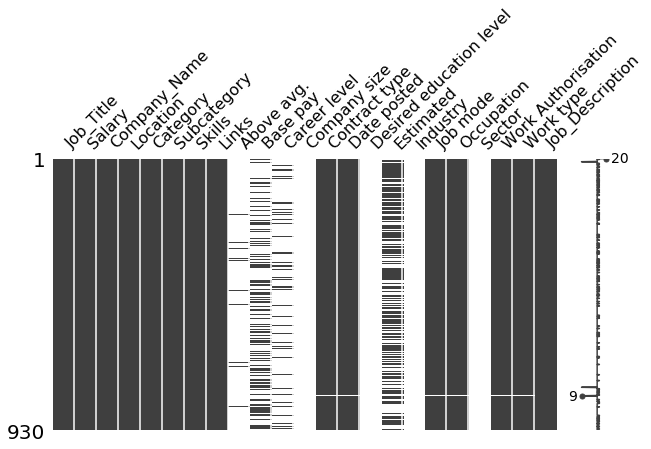

In [11]:
#Visualsing the missing values
msno.matrix(job_df,figsize=(10,5))

In [12]:
#Finding out the exact proportion of missing values
job_df.isnull().mean().sort_values(ascending=False)

Company size               0.998925
Sector                     0.998925
Industry                   0.998925
Desired education level    0.998925
Above avg.                 0.950538
Career level               0.841935
Base pay                   0.649462
Estimated                  0.403226
Contract type              0.003226
Work type                  0.003226
Date posted                0.003226
Job mode                   0.003226
Occupation                 0.003226
Work Authorisation         0.003226
Category                   0.000000
Salary                     0.000000
Company_Name               0.000000
Location                   0.000000
Job_Description            0.000000
Subcategory                0.000000
Skills                     0.000000
Links                      0.000000
Job_Title                  0.000000
dtype: float64

In [13]:
#These columns have too many missing values in them, and will be automatically dropped
#The pay related columns are redundant with the 'Salary' column so they will also be automatically dropped
cols_to_drop = ['Company size','Sector','Industry','Desired education level','Above avg.','Career level','Base pay',
                'Estimated']

job_df.drop(columns=cols_to_drop,inplace=True)

In [14]:
#Checking the number of remaining missing values, since it is only 3, we can remove them automatically
job_df.isnull().sum().sort_values(ascending=False)

Work type             3
Work Authorisation    3
Occupation            3
Job mode              3
Date posted           3
Contract type         3
Job_Description       0
Links                 0
Skills                0
Subcategory           0
Category              0
Location              0
Company_Name          0
Salary                0
Job_Title             0
dtype: int64

In [15]:
#Assigning a row mask corresponding to the missing values
rows_to_drop = job_df[job_df['Work type'].isnull()].index
job_df.drop(index=rows_to_drop,inplace=True)

In [16]:
#Checking once more for missing values
job_df.isnull().sum()

Job_Title             0
Salary                0
Company_Name          0
Location              0
Category              0
Subcategory           0
Skills                0
Links                 0
Contract type         0
Date posted           0
Job mode              0
Occupation            0
Work Authorisation    0
Work type             0
Job_Description       0
dtype: int64

**Removing non-data related jobs**

* Since the search was done under the one search term 'data' there could be non data related postings

In [17]:
#Checking the unique job categories, and removing accordingly
job_df['Category'].value_counts()

Information Technology (IT)                 560
Administration & Office Support             189
Banking, Superannuation & Finance            31
Science, Technology & Environment            19
Government, Emergency Services & Defence     16
Trades & Services                            16
Executive Management & Consulting            16
Accounting                                   12
Marketing & Advertising                      11
Education, Training & Childcare               9
Sales                                         9
Engineering                                   8
Healthcare & Medical                          8
Insurance                                     4
Transport & Logistics                         4
Retail                                        2
Mining & Energy                               2
Construction                                  2
Human Resources (HR) & Recruitment            2
Legal                                         2
Manufacturing, Production & Operations  

In [18]:
#List of categories I've gone over and deduced to be non-data related and have been dropped
categories = ['Customer Service & Call Centre','Manufacturing, Production & Operations','Design & Architecture',
              'Legal', 'Construction','Retail','Human Resources (HR) & Recruitment',
             'Transport & Logistics','Healthcare & Medical','Sales','Trades & Services','Accounting']

#Here are specific rows I've identified as wanting to drop
rows_to_get_rid = [59,98,473,489,108,490,547,583,747,793,833,2,282,322,404,927]

* **NB:** There are probably more non-data related jobs, but it will take far too long to go over every single row, so I am just culling jobs in categories that are most likely to be non-data related.

In [19]:
#Generating the row masks in a list so they can be iterated and removed below
row_masks = [job_df[job_df['Category'] == category].index for category in categories]

#Iterating through the masks and removing them
for mask in row_masks:
    job_df.drop(index=mask,inplace=True)

In [20]:
#Iterating through the specific rows I specified above and removing them accordingly
for row in rows_to_get_rid:
    job_df.drop(index=row,inplace=True)

In [21]:
#Checking again if the categories have been removed
job_df['Category'].value_counts()

Information Technology (IT)                 560
Administration & Office Support             189
Banking, Superannuation & Finance            31
Science, Technology & Environment            19
Government, Emergency Services & Defence     16
Executive Management & Consulting            16
Marketing & Advertising                      11
Education, Training & Childcare               4
Insurance                                     1
Engineering                                   1
Mining & Energy                               1
Property & Real Estate                        1
Social Work & Community Services              1
Name: Category, dtype: int64

**Removing extra or redundant columns**

* Since I am preparing my dataframe for modelling, I will go through and remove columns that are unnecessary to include in the dataset. 

In [22]:
#Occupation has the exact same information as 'Subcategory' so will be removed
job_df.drop(columns='Occupation',inplace=True)

In [23]:
#Links are irrelevant now to the modelling process
job_df.drop(columns='Links',inplace=True)

In [24]:
#Date of posting is also completely irrelvant
job_df.drop(columns='Date posted',inplace=True)

**More formatting and cleaning**

* There are still a few badly formatted columns that will need to be adjusted in order to be modeled correctly

In [25]:
#Defining a function that converts all the locations into just the state names
def location_clean(x):
    if 'NSW' in x:
        return 'NSW'
    if 'VIC' in x:
        return 'VIC'
    if 'ACT' in x:
        return 'ACT'
    if 'QLD' in x:
        return 'QLD'
    if 'WA' in x:
        return 'WA'
    if 'SA' in x:
        return 'SA'
    if 'TAS' in x:
        return 'TAS'
    if 'NT' in x:
        return 'NT'
    else:
        return 'Not_specified'

In [26]:
#Applying the above function to a new column
job_df['State'] = job_df['Location'].apply(location_clean)

#Dropping the location column
job_df.drop(columns='Location',inplace=True)

In [27]:
#Cleaning the skills column so it removes any unnecessary special characters and quotations around each word
#This is so it can be used for NLP analysis later on
job_df['Skills'] = job_df['Skills'].apply(lambda x:x.replace('[','').replace(']','').replace("'","").replace(',',''))

**Dealing with low variance**

* Next step is to deal with low variance or homogeneous columns

In [28]:
#Pasting in a method from my previous project, that takes in a dataframe and prints the column with its majority class
#over a specified threshold limit
def var_checker(df,thresh):
    for col in df:
        #Checks if the values in the column are 'numeric', if it is numeric it is assumed to be a continuous variable
        #and therefore excluded, we only want categorical variables
        if all(df[col].apply(lambda x:str(x).isnumeric())) == False:
            if df[col].value_counts(normalize=True).max() > thresh:
                print(col) 
                print(dict(df[col].value_counts()))
                print('-------------------')

In [29]:
#Checking for a threshold over 80% one class in a column
var_checker(job_df,0.8)

Job mode
{'Standard/Business Hours': 834, 'Weekend': 17}
-------------------
Work Authorisation
{'Australian Citizen/Permanent Resident': 840, 'Work/Holiday Visa': 9, 'Permanent Resident': 2}
-------------------
Work type
{'Full Time': 842, 'Part Time': 7, 'Casual/Holiday': 2}
-------------------


* We can see there are three columns that are highly homogeneous. I will remove all of them, as not only are they homogeneous, but I think they will be poor predictors of Salary anyway.

In [30]:
#Dropping the homogeneous columns
job_df.drop(columns=['Job mode','Work Authorisation','Work type'],inplace=True)

In [31]:
#Dropping company name, as it is not a valid predictor
job_df.drop(columns='Company_Name',inplace=True)

In [32]:
job_df.reset_index(drop=True,inplace=True)

**Removing and cleaning infrequently occurring classes from the columns**

In [33]:
#Identifying the very infrequently occurring categories
job_df['Category'].value_counts()

Information Technology (IT)                 560
Administration & Office Support             189
Banking, Superannuation & Finance            31
Science, Technology & Environment            19
Government, Emergency Services & Defence     16
Executive Management & Consulting            16
Marketing & Advertising                      11
Education, Training & Childcare               4
Insurance                                     1
Engineering                                   1
Mining & Energy                               1
Property & Real Estate                        1
Social Work & Community Services              1
Name: Category, dtype: int64

In [34]:
#Putting the infrequent columns in a list
to_roll = ['Engineering','Insurance','Social Work & Community Services','Mining & Energy','Property & Real Estate',
           'Education, Training & Childcare','Marketing & Advertising']

#Applying the rolling function to the category column
job_df['Category'] = job_df['Category'].apply(lambda x : 'Other' if x in to_roll else x)

In [35]:
#Internship & Trainee only occurs once, so that will also be dropped
drop_ind = job_df[job_df['Contract type'] == 'Internship & Trainee'].index
job_df.drop(index=drop_ind,inplace=True)

In [36]:
job_df.reset_index(drop=True,inplace=True)

In [37]:
job_df

,Job_Title,Salary,Category,Subcategory,Skills,Contract type,Job_Description,State
0,ICT Business Analyst/Data Specialist,100000.0,Information Technology (IT),Business/Systems Analysts (IT),COMMUNICATION DATA ANALYTICS DATA COLLECTION I...,Permanent,Company Profile: Intersurgical is a lead...,NSW
1,Senior Data Engineer,162500.0,Information Technology (IT),IT Management & Senior Leadership,AMAZON KINESIS AWS DATA SOURCES DATA TRANSFORM...,Permanent,Are you an experienced Data Engineer tha...,VIC
2,Data Analyst/Modeller x 4,162000.0,Information Technology (IT),IT Management & Senior Leadership,API DATA ANALYST DATA ANALYTICS DATA WAREHOUSI...,Contract,Data Analyst/Modeller x 4 initial contr...,ACT
3,Data Entry | Temporary,52500.0,Administration & Office Support,Data Entry,COMMUNICATION MICROSOFT WORD,Contract,A great opportunity to join a market lea...,NSW
4,Data Administrator,60000.0,Administration & Office Support,Administration Assistants,ACCURATE DATA ENTRY,Contract,Data Administrator Kelly Services are a ...,WA
5,Platform Engineer - Data,101000.0,Information Technology (IT),Software Engineering,AWS DATA WAREHOUSING ETL TEAM BUILDING,Permanent,Play with the latest data toolsASX liste...,NSW
6,Data Coordinator,60000.0,Administration & Office Support,Administration Assistants,MICROSOFT EXCEL MICROSOFT OUTLOOK SELF MOTIVATED,Contract,Technical Administrator FMCG Organisati...,NSW
7,Data Analytics Manager,100500.0,Information Technology (IT),IT Management & Senior Leadership,COMMUNICATION CONTINUOUS IMPROVEMENT DATA ANAL...,Permanent,Data Analytics Role | 2 Year Fix Term C...,VIC
8,APS6 Data Analyst,125000.0,Information Technology (IT),Business/Systems Analysts (IT),BUSINESS REQUIREMENTS COMMUNICATION DATA ANALY...,Contract,Work for the largest Government Departm...,ACT
9,Sustainability Data Analyst,100000.0,Information Technology (IT),Business/Systems Analysts (IT),COMMUNICATION DATA ANALYST JSON MARKETING ANAL...,Contract,Great Team Culture Prime location in Sy...,NSW


## 3. Modeling the data: Factors determining salary (Question 1)

* The data frame is now ready to be modeled. I will construct four different models in total, the first two will be based on a list of key words that I myself have chosen as being relevant and important to predicting a data science salary. They will then be combined with the state, the contract type and the category. I will then fit them on a linear regression model and a random forest regressor. 


* The next two models will be modeled only on all the words in job title, skills (strong words), and job description. They will also be fitted to a linear regression model and random forest regressor, but I will do some feature engineering (PCA etc.) to clean the model.

In [38]:
#Importing the necessary packages for modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [39]:
#Defining a baseline RMSE function that will be used later for assessing the performance of my models
def baseline(y_actual):
    #The mean of the actual test data
    meanprice = y_actual.mean()
    #Generating an array of means from which we can minus from the observed data
    nullprediction = [meanprice for i in range(len(y_actual))]
    #Finally returning the mse for from the means
    return np.sqrt(mean_squared_error(y_actual,  nullprediction))

In [40]:
#Defining a baseline MAE function that will be used later for assessing performance of my models
def baseline_abs(y_actual):
    meanprice=y_actual.mean()
    nullpred = [meanprice for i in range(len(y_actual))]
    return mean_absolute_error(y_actual,nullpred)

### Top keywords model:

**Linear Model**

In [41]:
#These are the keywords that will be the basis for my vectorised model, this will be passed in as the vocab for my
#count vectoriser
keyword_list = ["python", "hadoop","big data", "sql", "nlp", "excel", "deep learning", "phd", "mongodb",
             "cassandra", "machine learning", "masters","pandas","data science","bi","business intelligence","aws",
             "tableau","office","vba","visual basic","java","analyst","scientist","consultant","data entry",
             "neural networks","computer science","communication","project management","spark"]

In [42]:
#Instantiating my count vectoriser object with my vocab, and using the ngram_range (1,2) because I want to capture
#individual words and combinations of two words
cvec = CountVectorizer(vocabulary=keyword_list,ngram_range=(1,2),stop_words='english')

#Splitting up the text columns so they can be vectorised properly
X_skill = job_df['Skills']
skill_model = cvec.fit(X_skill)
#Putting it into a dataframe where I will combine later
skill_df = pd.DataFrame(skill_model.transform(X_skill).todense(),
                       columns=skill_model.get_feature_names())

X_job_title = job_df['Job_Title']
job_title_model = cvec.fit(X_job_title)
job_title_df = pd.DataFrame(job_title_model.transform(X_job_title).todense(),
                       columns=job_title_model.get_feature_names())

X_description = job_df['Job_Description']
description_model = cvec.fit(X_description)
description_df = pd.DataFrame(description_model.transform(X_description).todense(),
                       columns=description_model.get_feature_names())

In [43]:
#This simply adds up the occurrences of all the words in each job description
aggregate_df = (skill_df + job_title_df + description_df)
aggregate_df

,python,hadoop,big data,sql,nlp,excel,deep learning,phd,mongodb,cassandra,machine learning,masters,pandas,data science,bi,business intelligence,aws,tableau,office,vba,visual basic,java,analyst,scientist,consultant,data entry,neural networks,computer science,communication,project management,spark
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0
1,1,0,3,5,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0
8,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0
9,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,2,0,0


In [44]:
#Now defining my predictor matrix
predictor_matrix = job_df[['Category','Contract type','State']]
#Converting to dummie variables
predictor_matrix = pd.get_dummies(predictor_matrix)

#Concatenating the dummie matrix to the vectorised matrix to construct my final predictor matrix
predictor_matrix = pd.concat([predictor_matrix,aggregate_df],axis=1)

In [45]:
#Now defining my predictor and target
X = predictor_matrix
y = job_df['Salary']

In [46]:
#Fitting them to a simple linear regression model
lm = LinearRegression()
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
#Scoring the model based on MAE, RMSE and R^2 and comparing to the baseline
scores_abs = cross_val_score(lm,X,y,cv=10,scoring='neg_mean_absolute_error')
scores_mse = cross_val_score(lm,X,y,cv=10,scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(lm,X,y,cv=10,scoring='r2')

scores_abs = [score*-1 for score in scores_abs]
scores_rmse = [np.sqrt(score*-1) for score in scores_mse]

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline abs:',baseline_abs(y))
print('Baseline rmse',baseline(y))
print('-----------')
print('Model cv abs mean:',np.mean(scores_abs),'std:',np.std(scores_abs))
print('Model cv rmse mean:',np.mean(scores_rmse),'std:',np.std(scores_rmse))
print('Model cv r2 mean:',np.mean(scores_r2),'std:',np.std(scores_r2))

Model performance:
-----------
Baseline abs: 33897.816747404846
Baseline rmse 42418.1226543137
-----------
Model cv abs mean: 21296.164739663174 std: 2115.858753781163
Model cv rmse mean: 28519.667224915822 std: 2711.985115626733
Model cv r2 mean: 0.516215638394588 std: 0.11279181018990823


* The model is performing at a decent level already, with a mean r^2 of 0.51, it's far from perfect but, as the mean absolute error and root mean squared error suggest, it is outperforming the baseline at estimating salary based on the occurrences of these keywords in each job description.

In [48]:
#Generating the coefficients and seeing which ones make the largest postivie/negative impact on the salary.
coefs = pd.DataFrame(dict(zip(X,lm.coef_)),index=[0]).T
coefs.rename(columns={0:'Value'},inplace=True)
coefs['ABS_Value'] = coefs['Value'].apply(lambda x:abs(x))
coefs.sort_values(by='ABS_Value',ascending=False)

,Value,ABS_Value
Category_Administration & Office Support,-30611.976565,30611.976565
Category_Information Technology (IT),18801.250572,18801.250572
Category_Executive Management & Consulting,18551.907202,18551.907202
State_NT,-17027.667007,17027.667007
visual basic,-15903.417879,15903.417879
neural networks,11705.830845,11705.830845
cassandra,-11377.650681,11377.650681
State_VIC,10894.630721,10894.630721
Category_Other,-10560.566632,10560.566632
phd,8689.865257,8689.865257


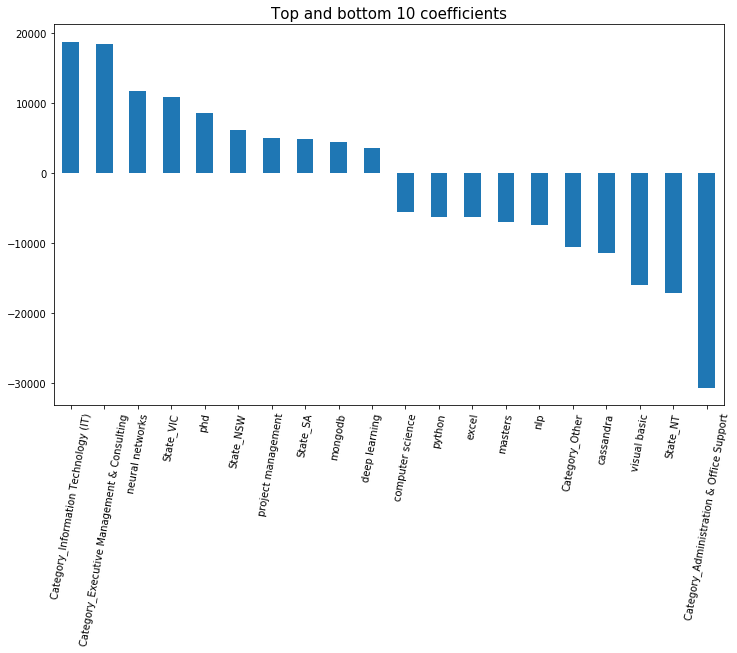

In [50]:
high = coefs.sort_values(by='Value',ascending=False).head(10)
low = coefs.sort_values(by='Value',ascending=False).tail(10)

plt.figure(figsize=(12,7))
grph = pd.concat([high,low],axis=0)['Value'].plot(kind='bar')
grph.axes.set_xticklabels(pd.concat([high,low],axis=0).index,rotation=80)
plt.title('Top and bottom 10 coefficients',fontsize=15)
plt.show()

* As we can see we do already gain some interesting insights from the model. With Administration & Office support category jobs having a negative impact on the salaries, while jobs in banking and finance have the largest positive impact. No surprises there. 


* On a location basis, jobs in the Northern Territory also have a negative impact on salary, which also makes sense as it's a low demand area to work in. 


* Finally the occurrence of 'mongodb' has a positive impact on salary, while the occurrence of 'big data' has a negative impact on salary.

**Lasso to improve the model**

* I will do a quick lasso regularisation to see which features can be taken out and I will remodel based on what it finds

In [51]:
l1_ratios = np.linspace(0.01, 1.0, 100)

#Using the ElasticNetCV to find the optimal l1 ratio and alpha, cross validating over 10 folds, verbose=1 to reduce
#computational processing time
opt_en = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1,n_jobs=-1)
opt_en.fit(X,y)

#Printing out what the optimal alpha and ratio was
print('Optimal alpha is',opt_en.alpha_)
print('Optimal ratio is',opt_en.l1_ratio_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal alpha is 264.8095589562033
Optimal ratio is 1.0


In [52]:
#Putting the optimal ratio and alpha into an elastic net model
en = ElasticNet(alpha = opt_en.alpha_,l1_ratio=opt_en.l1_ratio_)

In [53]:
#Putting the coefficients in a dataframe and analysing which ones were regularised to 0
en_coefs = pd.DataFrame(dict(zip(X.columns,en.fit(X,y).coef_)),index=['Value']).T
en_coefs['ABS_Value'] = en_coefs['Value'].apply(lambda x:abs(x))
en_coefs.sort_values(by='ABS_Value',ascending=False)

,Value,ABS_Value
Category_Administration & Office Support,-24025.124972,24025.124972
Category_Information Technology (IT),15782.315751,15782.315751
State_VIC,8002.252275,8002.252275
data entry,-7291.617622,7291.617622
python,-6153.759601,6153.759601
excel,-6026.278988,6026.278988
analyst,-4964.484902,4964.484902
project management,4404.223374,4404.223374
State_NSW,3982.197159,3982.197159
Contract type_Contract,3410.530592,3410.530592


In [54]:
#Identifying the indices that were not reduced to 0
en_mask = en_coefs[en_coefs['Value'] != 0].index

In [55]:
#Constructing a new predictor matrix with only non regularised values
en_X = X[en_mask]

In [56]:
#Fitting it to a new model
en_lm = lm.fit(en_X,y)

In [57]:
#Getting scores base on MAE,RMSE and R^2
scores_abs_en = cross_val_score(lm,en_X,y,cv=10,scoring='neg_mean_absolute_error')
scores_mse_en = cross_val_score(lm,en_X,y,cv=10,scoring='neg_mean_squared_error')
scores_r2_en = cross_val_score(lm,en_X,y,cv=10,scoring='r2')

scores_abs_en = [score*-1 for score in scores_abs_en]
scores_rmse_en = [np.sqrt(score*-1) for score in scores_mse_en]

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline abs:',baseline_abs(y))
print('Baseline rmse',baseline(y))
print('-----------')
print('Model cv abs mean:',np.mean(scores_abs_en),'std:',np.std(scores_abs_en))
print('Model cv rmse mean:',np.mean(scores_rmse_en),'std:',np.std(scores_rmse_en))
print('Model cv r2 mean:',np.mean(scores_r2_en),'std:',np.std(scores_r2_en))

Model performance:
-----------
Baseline abs: 33897.816747404846
Baseline rmse 42418.1226543137
-----------
Model cv abs mean: 20940.512726869107 std: 2317.4608716490766
Model cv rmse mean: 27873.857928823483 std: 3353.458848853928
Model cv r2 mean: 0.534748252423755 std: 0.12758806943236525


* As we can see the lasso made a slight improvement to model across all scoring methods, woo!

In [58]:
#Putting the coefficient values into a dataframe to see their impact
en_lm_coefs = pd.DataFrame(dict(zip(en_X.columns,en_lm.coef_)),index=['Value']).T
en_lm_coefs['ABS_Value'] = en_lm_coefs['Value'].apply(lambda x:abs(x))
en_lm_coefs.sort_values(by='ABS_Value',ascending=False)

,Value,ABS_Value
Category_Administration & Office Support,-29682.790344,29682.790344
Category_Executive Management & Consulting,19409.622543,19409.622543
Category_Information Technology (IT),19276.398888,19276.398888
cassandra,-10823.629893,10823.629893
State_VIC,9189.229794,9189.229794
python,-6937.320838,6937.320838
excel,-6164.544973,6164.544973
State_QLD,-5800.326974,5800.326974
analyst,-5275.719638,5275.719638
Contract type_Contract,5231.670621,5231.670621


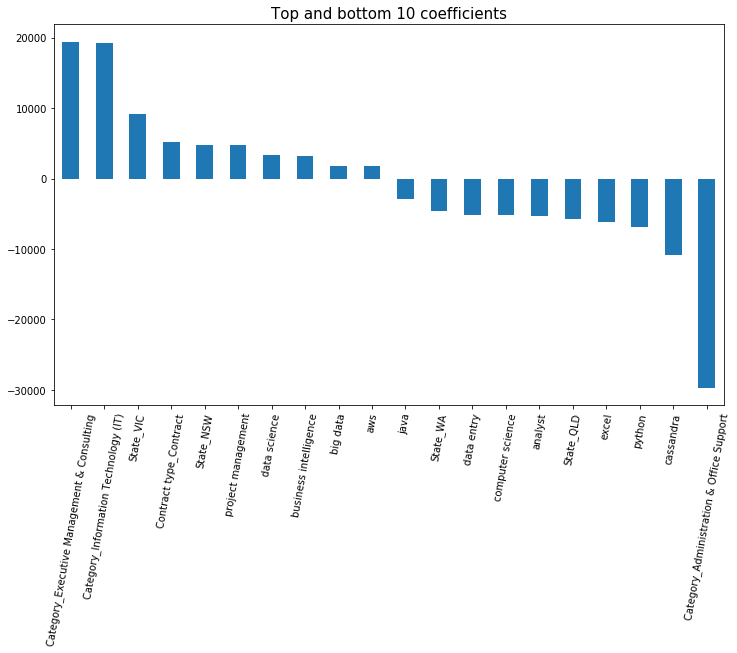

In [59]:
high = en_lm_coefs.sort_values(by='Value',ascending=False).head(10)
low = en_lm_coefs.sort_values(by='Value',ascending=False).tail(10)

plt.figure(figsize=(12,7))
grph = pd.concat([high,low],axis=0)['Value'].plot(kind='bar')
grph.axes.set_xticklabels(pd.concat([high,low],axis=0).index,rotation=80)
plt.title('Top and bottom 10 coefficients',fontsize=15)
plt.show()

* Similar results as before though with job postings based in Victoria now having a positive impact on salary. 


* What else is interesting, is that now IT job categories have a positive impact on salaries now.

**Random Forest**

* Now I will model the same features on a random forest model. I am not expecting a huge improvement, and while the coefficient values will be lost, this model will be able to rank the features from most important to least, giving a new insight into factors that might influence data science salaries.


* For this model, I will gridsearch the hyperparamters for the random forest model:

In [60]:
#Instantiating the random forest regressor model
rf = RandomForestRegressor()

In [61]:
#Setting the depths to gridsearch over as 1 to 32 and appending 'None' to encapsulate the no depths option
depths = list(range(1,33))
depths.append(None)

#Setting parameters looking over the different bootstrap options, the different number of estimators and sample splits
params = {
    'bootstrap':[True,False],
    'n_estimators':[10,50,100],
    'max_depth' : depths,
    'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True)
}

In [62]:
rf_opt = GridSearchCV(rf,params,cv=5,verbose=1,n_jobs=-1)

In [63]:
#Fitting it to the X and y and gridsearching...this may take a while
rf_opt.fit(X,y)

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 6730 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 8856 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 9900 out of 9900 | elapsed:  7.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
     

In [64]:
rf_opt.best_params_

{'bootstrap': True,
 'max_depth': 19,
 'min_samples_split': 0.1,
 'n_estimators': 10}

In [65]:
#Fitting a new model with the best estimator from the gridsearch, this will be the basis for my scoring and feature
#ranking
rf_model = rf_opt.best_estimator_.fit(X,y)

In [66]:
scores_abs_rf = cross_val_score(rf_model,X,y,cv=10,scoring='neg_mean_absolute_error')
scores_mse_rf = cross_val_score(rf_model,X,y,cv=10,scoring='neg_mean_squared_error')
scores_r2_rf = cross_val_score(rf_model,X,y,cv=10,scoring='r2')

scores_abs_rf = [score*-1 for score in scores_abs_rf]
scores_rmse_rf = [np.sqrt(score*-1) for score in scores_mse_rf]

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline abs:',baseline_abs(y))
print('Baseline rmse',baseline(y))
print('-----------')
print('Model cv abs mean:',np.mean(scores_abs_rf),'std:',np.std(scores_abs_rf))
print('Model cv rmse mean:',np.mean(scores_rmse_rf),'std:',np.std(scores_rmse_rf))
print('Model cv r2 mean:',np.mean(scores_r2_rf),'std:',np.std(scores_r2_rf))

Model performance:
-----------
Baseline abs: 33897.816747404846
Baseline rmse 42418.1226543137
-----------
Model cv abs mean: 19983.66317531134 std: 2792.18499684252
Model cv rmse mean: 27944.16767117222 std: 2995.4139023293747
Model cv r2 mean: 0.5434390720979082 std: 0.1172884856227676


* As we can see, another across the board improvement on all scoring methods, compared to the previous linear regression model. Starting from 0.51 to 0.55 r^2 is a solid improvement.

In [67]:
rf_feats = pd.DataFrame(dict(zip(X.columns,rf_model.feature_importances_)),index=['Value']).T
rf_feats.sort_values(by='Value',ascending=False)

,Value
data entry,0.455255
Category_Administration & Office Support,0.313239
analyst,0.052763
excel,0.047451
Category_Information Technology (IT),0.014283
data science,0.011201
office,0.011179
python,0.009255
project management,0.008719
machine learning,0.006748


<Figure size 864x504 with 0 Axes>

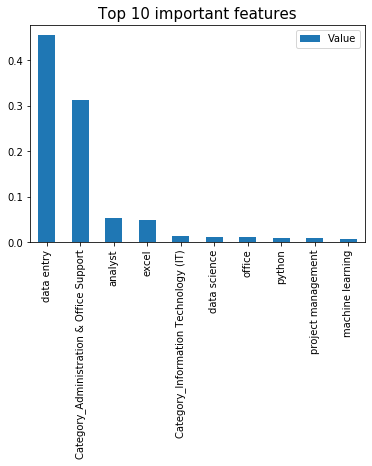

In [68]:
plt.figure(figsize=(12,7))
rf_feats.sort_values(by='Value',ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 important features',fontsize=15)
plt.show()

* Now for the feature importances. Interestingly enough, these features share quite a few differences to the values of the coefficients in the linear regression model. The occurrence of 'data entry' in job listings being ranked the most important. This is interesting, as, from a non-scientific stand point I observed many data entry jobs being much lower paid than other data jobs, so perhaps this is why it was ranked as such an important feature. 


* The admin and office support category also make an appearance. This also makes sense as a lot of data entry jobs were under the admin and office support category.

**Random forest model with lasso features**

* Since I already have the lasso'd coefficients, I will build another random forest model based on the new list.

In [69]:
#Grid searching and fitting based on the same parameters but just over the elastic netted indices
rf_opt_en = GridSearchCV(rf,params,cv=5,verbose=1,n_jobs=-1)
rf_opt_en.fit(en_X,y)

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2066 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3266 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4016 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4866 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 6610 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 8710 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 9900 out of 9900 | elapsed:  6.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
     

In [70]:
#Fitting the best estimator to a new model
rf_en_model = rf_opt_en.best_estimator_.fit(en_X,y)

In [71]:
scores_abs_rf_en = cross_val_score(rf_en_model,X,y,cv=10,scoring='neg_mean_absolute_error')
scores_mse_rf_en = cross_val_score(rf_en_model,X,y,cv=10,scoring='neg_mean_squared_error')
scores_r2_rf_en = cross_val_score(rf_en_model,X,y,cv=10,scoring='r2')

scores_abs_rf_en = [score*-1 for score in scores_abs_rf_en]
scores_rmse_rf_en = [np.sqrt(score*-1) for score in scores_mse_rf_en]

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline abs:',baseline_abs(y))
print('Baseline rmse',baseline(y))
print('-----------')
print('Model cv abs mean:',np.mean(scores_abs_rf_en),'std:',np.std(scores_abs_rf_en))
print('Model cv rmse mean:',np.mean(scores_rmse_rf_en),'std:',np.std(scores_rmse_rf_en))
print('Model cv r2 mean:',np.mean(scores_r2_rf_en),'std:',np.std(scores_r2_rf_en))

Model performance:
-----------
Baseline abs: 33897.816747404846
Baseline rmse 42418.1226543137
-----------
Model cv abs mean: 19903.268019749037 std: 2545.683639414353
Model cv rmse mean: 27602.202984888725 std: 3126.9353967193315
Model cv r2 mean: 0.5481263310045236 std: 0.11581468426359152


* As we can see, not really much of an improvement, quite the opposite, with all measures of scoring doing worse than the non-lasso'd random forest model. One can infer that lasso'ing the features does not yield such a dramatic improvement as it would with a linear regression model.

In [72]:
rf_en_feats = pd.DataFrame(dict(zip(en_X.columns,rf_en_model.feature_importances_)),index=['Value']).T
rf_en_feats.sort_values(by='Value',ascending=False)

,Value
data entry,0.452228
Category_Administration & Office Support,0.318807
analyst,0.057205
excel,0.042702
Category_Information Technology (IT),0.020564
data science,0.014561
office,0.013974
python,0.010894
project management,0.009834
State_VIC,0.009533


<Figure size 864x504 with 0 Axes>

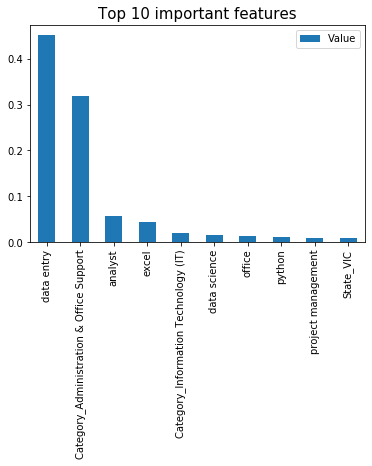

In [73]:
plt.figure(figsize=(12,7))
rf_en_feats.sort_values(by='Value',ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 important features',fontsize=15)
plt.show()

* Much like the previous random forest model, the feature importances are the same.

### All words model 

* This next model will be only modeled on the occurrences of words in the job postings. The amount of columns will be extremely large, so I believe a random forest or decision tree model will be necessary, however, I will stick to using a linear regression first to highlight how much better/worse a random forest model can be in handling large amounts of features.

In [74]:
#Making a new series object that combines all the words from job title, skills and job description into one big corpus
combined = (job_df['Job_Title'] + ' ' + job_df['Skills'] + ' ' + job_df['Job_Description'])

* Now that I have a corpus, I will do grid of what countvectoriser hyperparameters I should use to yield the best result with a linear regression model. To achieve this, I will do a pipeline.

**All word linear model**

In [75]:
#Making a pipeline that will count vectorise and fit to a linear regression model, this will optimise the count
#vectoriser hyper parameters to give me the best score
lm_pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('lm',LinearRegression())
])

In [76]:
#Setting the range of parameters I want to grid search over to yield the best scoring model
cvec_params = {
 #Setting an upper limit of 50k features, as any bigger would be unwieldy for a linear regression model  
 'cvec__max_features': list(range(1000,50000,5000)),
 'cvec__ngram_range': [(1, 1),(1, 2),(2, 2)],
 'cvec__stop_words': ['english'],
  #Grid searching for the lowest bound of occurrences of a word before it is ignored
 'cvec__min_df': list(range(1,20)) 
}

In [77]:
#fitting the model
lm_pipe.fit(combined,y)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lm',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [78]:
#Setting up the grid search object to search over
lm_pipe_GS = GridSearchCV(lm_pipe,cvec_params,cv=5,verbose=1,n_jobs=-1)

In [79]:
#Fitting it and waiting 38 god damn minutes for it to run
lm_pipe_GS.fit(combined,y)

Fitting 5 folds for each of 570 candidates, totalling 2850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 2850 out of 2850 | elapsed: 44.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [80]:
#Outputting the best parameters
lm_pipe_GS.best_params_

{'cvec__max_features': 46000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (2, 2),
 'cvec__stop_words': 'english'}

In [81]:
lm_best_model = lm_pipe_GS.best_estimator_

In [82]:
#Scoring the model based on the best estimator
scores_abs_allw = cross_val_score(lm_best_model,combined,y,cv=10,scoring='neg_mean_absolute_error')
scores_mse_allw = cross_val_score(lm_best_model,combined,y,cv=10,scoring='neg_mean_squared_error')
scores_r2_allw = cross_val_score(lm_best_model,combined,y,cv=10,scoring='r2')

scores_abs_allw = [score*-1 for score in scores_abs_allw]
scores_rmse_allw = [np.sqrt(score*-1) for score in scores_mse_allw]

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline abs:',baseline_abs(y))
print('Baseline rmse',baseline(y))
print('-----------')
print('Model cv abs mean:',np.mean(scores_abs_allw),'std:',np.std(scores_abs_allw))
print('Model cv rmse mean:',np.mean(scores_rmse_allw),'std:',np.std(scores_rmse_allw))
print('Model cv r2 mean:',np.mean(scores_r2_allw),'std:',np.std(scores_r2_allw))

Model performance:
-----------
Baseline abs: 33897.816747404846
Baseline rmse 42418.1226543137
-----------
Model cv abs mean: 19406.737394164382 std: 2085.0609401841534
Model cv rmse mean: 26981.015533706908 std: 3354.6493091173693
Model cv r2 mean: 0.5719343439255904 std: 0.08280098796513835


* As we can see this linear regression model has outperformed the previous key words model but a decent margin. It has outperformed across the board with all measures of performance, even without optimisation. I am quite surprised by the results, but it is a pleasant surprise! 

In [83]:
#Putting the vectorised names into a dataframe so i can analyse the coefficients
names = pd.DataFrame(lm_best_model.named_steps['cvec'].transform(combined).todense(),
                       columns=lm_best_model.named_steps['cvec'].fit(combined).get_feature_names())

In [84]:
#Now zipping it with the coefficient values to get the coefficient values
allw_coefs = pd.DataFrame(dict(zip(names.columns,lm_best_model.named_steps['lm'].coef_)),index=['Value']).T
allw_coefs['ABS_Value'] = allw_coefs['Value'].apply(lambda x:abs(x))
allw_coefs.sort_values(by='ABS_Value',ascending=False)

,Value,ABS_Value
administration data,13872.276366,13872.276366
hr administrative,13114.782121,13114.782121
melbourne kpmg,-13062.005727,13062.005727
positiondatamelbourne kpmg,13003.359031,13003.359031
hour administrative,12900.496544,12900.496544
time visualization,12491.341436,12491.341436
learning real,12215.690678,12215.690678
management hadoop,12074.326038,12074.326038
associate director,-12061.127089,12061.127089
hadoop machine,11985.188248,11985.188248


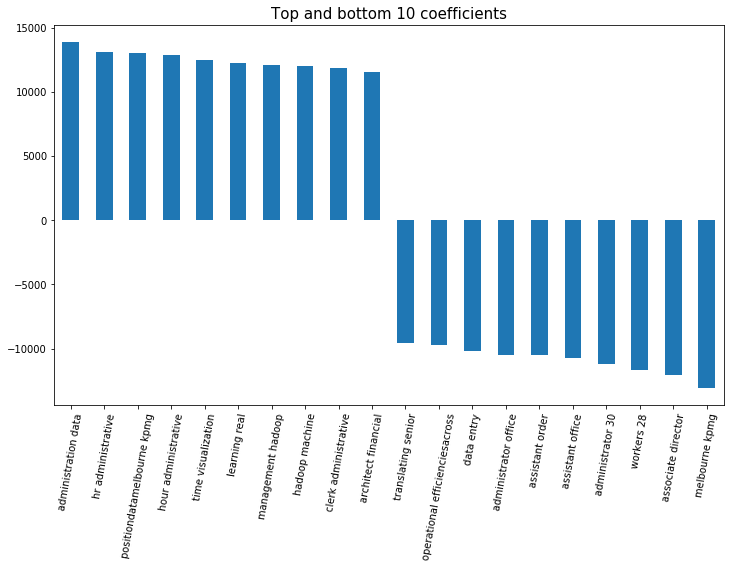

In [85]:
high = allw_coefs.sort_values(by='Value',ascending=False).head(10)
low = allw_coefs.sort_values(by='Value',ascending=False).tail(10)

plt.figure(figsize=(12,7))
grph = pd.concat([high,low],axis=0)['Value'].plot(kind='bar')
grph.axes.set_xticklabels(pd.concat([high,low],axis=0).index,rotation=80)
plt.title('Top and bottom 10 coefficients',fontsize=15)
plt.show()

* Quite different to the previous model we can see that the occurrence of 'administration data' has the most positive impact on salary closely followed by 'hr administrative'. Interestingly enough 'melbourne kpmg' has the greatest negative impact. I am not sure why a phrase so specific made it to the coefficient list, but perhaps it is an outlier or anomaly. I suspect that the random forest's feature importance will give better insight into feature importances.

**All word random forest model**

* The final model is a random forest regressor. I suspect that it will be the best performing model and random forests tend to perform quite well with large amounts of features, and would suit a count vectorised model quite well.

In [86]:
#Pipelining the count vectoriser and random forest regressor to grid search later
rf_pipe_allw = Pipeline([
    ('cvec',CountVectorizer()),
    ('rf',RandomForestRegressor())
])

In [87]:
#Setting parameters looking over the different bootstrap options, the different number of estimators and sample splits
params_allw = {
    'cvec__ngram_range': [(1, 1),(1, 2),(2, 2)],
    'cvec__stop_words': ['english'],
  #Grid searching for the lowest bound of occurrences of a word before it is ignored
    'cvec__min_df': list(range(1,20)) 
}

In [88]:
#Defining the grid search object
best_rf_allw = GridSearchCV(rf_pipe_allw,params_allw,cv=5,verbose=1,n_jobs=-1)

In [89]:
#Searching and waitng...
best_rf_allw.fit(combined,y)

Fitting 5 folds for each of 57 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:  5.0min finished
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [90]:
best_rf_allw.best_params_

{'cvec__min_df': 12,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [91]:
#Scoring based on the random forest gridsearch best estimator
scores_abs_allw_rf = cross_val_score(best_rf_allw.best_estimator_,combined,y,cv=10,scoring='neg_mean_absolute_error')
scores_mse_allw_rf = cross_val_score(best_rf_allw.best_estimator_,combined,y,cv=10,scoring='neg_mean_squared_error')
scores_r2_allw_rf = cross_val_score(best_rf_allw.best_estimator_,combined,y,cv=10,scoring='r2')

scores_abs_allw_rf = [score*-1 for score in scores_abs_allw_rf]
scores_rmse_allw_rf = [np.sqrt(score*-1) for score in scores_mse_allw_rf]

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline abs:',baseline_abs(y))
print('Baseline rmse',baseline(y))
print('-----------')
print('Model cv abs mean:',np.mean(scores_abs_allw_rf),'std:',np.std(scores_abs_allw_rf))
print('Model cv rmse mean:',np.mean(scores_rmse_allw_rf),'std:',np.std(scores_rmse_allw_rf))
print('Model cv r2 mean:',np.mean(scores_r2_allw_rf),'std:',np.std(scores_r2_allw_rf))

Model performance:
-----------
Baseline abs: 33897.816747404846
Baseline rmse 42418.1226543137
-----------
Model cv abs mean: 17882.955490196073 std: 2241.508686714878
Model cv rmse mean: 25969.067896364955 std: 3235.3177293434533
Model cv r2 mean: 0.5916700628381903 std: 0.09750074124993219


* As I had suspected, the random forest model has yielded the best results so far! Going ahead, I will use the insights gained from the feature importances of this model to draw my final conclusions on what factors might determine higher or lower salaries. 


* Quite obviously, the model has performed much better across the board than every other model, achieving a better mean and better standard deviation of the scores.

In [92]:
#Putting the names of the vectorised columns into a data frame
names_rf = pd.DataFrame(best_rf_allw.best_estimator_.named_steps['cvec'].transform(combined).todense(),
                       columns=best_rf_allw.best_estimator_.named_steps['cvec'].fit(combined).get_feature_names())

In [93]:
#Fitting the best estimator model
best_rf_allw.best_estimator_.fit(combined,y)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=12,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('rf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                

In [94]:
#Getting the feature importances
rf_feats_allw = best_rf_allw.best_estimator_.named_steps['rf'].feature_importances_

In [95]:
#Zipping the feature names and feature importance values into a dataframe for analysis
rf_en_allw = pd.DataFrame(dict(zip(names_rf.columns,rf_feats_allw)),index=['Value']).T
rf_en_allw.sort_values(by='Value',ascending=False)

,Value
entry,0.479591
architect,0.038990
excel,0.026943
lead,0.017237
analyst,0.014032
architecture,0.013065
data,0.009830
leadership,0.008298
head,0.007416
director,0.007082


<Figure size 864x504 with 0 Axes>

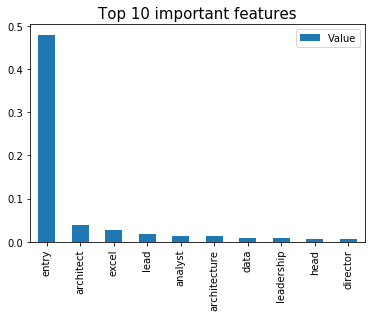

In [96]:
plt.figure(figsize=(12,7))
rf_en_allw.sort_values(by='Value',ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 important features',fontsize=15)
plt.show()

* As we can see, this list of features is far less specific and very different to the coefficients the linear regression model delivered before. We can see that data entry is the leader in feature importance, suggesting that it has the biggest impact on salary. This is in line with previous findings, as data entry is an entry level job and occurrences of this phrase we occur with lower salaries by the nature of it being a lower paid job.


* Other key words such as 'lead' and 'strategy' are also up there, I would suspect they'd have a more positive effect than 'data entry'. 


* Overall I'm impressed with the insights this model has produced, and in relation to all the other models we can get a good feel for what is a good predictor of data job salaries based on key words.

## Distinguishing data science and non data science roles (Question 2):

* For question two, I am only going to build a model that distinguishes data science from other data related jobs. I am only modeling it on this question as it is the only question I think I can build with some confidence with the data that I have. 


* I am going have my new target as whether the word 'data' or 'scientist' occurs in the job title of the job posting. The predictor matrix will be a corpus of all the words contained in the job description and in the skills (strong words). I will not be including any one hot encoded variables as I believe it will just add more noise. What I want to get from this model is the key words that determine a data scientist from other data related roles.


**Logistic Regression model**


* Firstly I will be building a simple Logistic Regression model. I am choosing logistic regression because I want to know the most I can about each coefficient, and which keywords classify a job posting as being a data science role or not.

In [97]:
#Defining my target as whether the job title has 'data' and 'scientist' in it, for classification
job_df['is_DS'] = job_df['Job_Title'].apply(lambda x : 1 if 'data' in x.lower() and 'scientist' in x.lower() else 0)
y_c = job_df['is_DS']

* Because anything with science will be too obvious of a classifier for whether a job is a data science role or not, I will be adding any 'science' related stop words to the stop word list.

In [98]:
#Making sklearn's stop words into a list
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS)

#Appending my own stop words to the list
custom_stop_words.append('science')
custom_stop_words.append('sciences')
custom_stop_words.append('scientist')
custom_stop_words.append('scientists')

In [99]:
#Making a new series object that combines all the words from job title, skills and job description into one big corpus
combined_c = (job_df['Skills'] + ' ' + job_df['Job_Description'])

In [100]:
#Making a pipeline that will count vectorise and fit to a logistic regression model, this will optimise the count
#vectoriser hyper parameters to give me the best score
lr_pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('lr',LogisticRegression())
])

In [101]:
#Setting the range of parameters I want to grid search over to yield the best scoring model
cvec_lr_params = {
 #Setting an upper limit of 50k features, as any bigger would be unwieldy for a logistic regression model  
 'cvec__max_features': list(range(1000,50000,5000)),
 'cvec__ngram_range': [(1, 1),(1, 2),(2, 2)],
 'cvec__stop_words': [custom_stop_words],
  #Grid searching for the lowest bound of occurrences of a word before it is ignored
 'cvec__min_df': list(range(1,20)) 
}

In [102]:
#Now putting the pipeline and parameters into a gridsearch object
lr_model_ideal = GridSearchCV(lr_pipe,cvec_lr_params,cv=5,verbose=1,n_jobs=-1)

In [103]:
#Fitting the model and waiting...again...
lr_model_ideal.fit(combined_c,y_c)

Fitting 5 folds for each of 570 candidates, totalling 2850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2850 out of 2850 | elapsed: 12.6min finished
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [104]:
#Getting the best parameters
lr_model_ideal.best_params_

{'cvec__max_features': 1000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['everywhere',
  'what',
  'others',
  'whole',
  'could',
  'whereas',
  'sometime',
  'full',
  'only',
  'anywhere',
  'via',
  'under',
  'then',
  'give',
  'ltd',
  'amoungst',
  'first',
  'do',
  'whether',
  'am',
  'these',
  'move',
  'upon',
  're',
  'about',
  'five',
  'one',
  'anything',
  'where',
  'sixty',
  'bill',
  'must',
  'us',
  'ie',
  'formerly',
  'at',
  'my',
  'below',
  'mostly',
  'two',
  'many',
  'however',
  'never',
  'none',
  'own',
  'with',
  'should',
  'may',
  'seemed',
  'the',
  'as',
  'they',
  'when',
  'get',
  'herein',
  'is',
  'anyway',
  'twelve',
  'whenever',
  'and',
  'without',
  'elsewhere',
  'by',
  'now',
  'three',
  'thin',
  'ourselves',
  'was',
  'after',
  'such',
  'already',
  'ever',
  'name',
  'yourself',
  'had',
  'throughout',
  'another',
  'enough',
  'part',
  'namely',
  'latter',
  'therefore',
  'mill'

In [105]:
#Fitting the most optimised model now
allw_classifier = lr_model_ideal.best_estimator_.fit(combined_c,y_c)

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [106]:
#Getting my predicted values for scoring
predicted = lr_model_ideal.best_estimator_.predict(combined_c)

In [107]:
#Defining the baseline accuracy as 1 - the mean (which is the largest occuring class in this case zero)
baseline_c = 1 - y_c.mean()

In [108]:
#Scoring based on best estimator from above
scores_acc = cross_val_score(lr_model_ideal.best_estimator_,combined_c,y_c,cv=10,scoring='accuracy')
scores_prec = cross_val_score(lr_model_ideal.best_estimator_,combined_c,y_c,cv=10,scoring='precision')
scores_rec = cross_val_score(lr_model_ideal.best_estimator_,combined_c,y_c,cv=10,scoring='recall')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline_c)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc),'std:',np.std(scores_acc))
print('Model cv prec mean:',np.mean(scores_prec),'std:',np.std(scores_prec))
print('Model cv rec mean:',np.mean(scores_rec),'std:',np.std(scores_rec))

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

Model performance:
-----------
Baseline accuracy 0.9341176470588235
-----------
Model cv acc mean: 0.9457934336525307 std: 0.020085369337126718
Model cv prec mean: 0.6833333333333333 std: 0.34520525295346627
Model cv rec mean: 0.41000000000000003 std: 0.2000277758490333


/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


* With an already very high baseline and imbalanced target data, I suspected there wasn't too much improvement I could have. However, as we can see, the model has performed above the baseline which is great!

* Although an accurate model isn't exactly what I was after, getting insights into the coefficients will now be more meaningful with a model that performs above the baseline.

In [109]:
#Custom confusion matrix dataframe maker
def confusion_matrix(y,predict):
    tp = np.sum((y == 1) & (predict == 1))
    fp = np.sum((y == 0) & (predict == 1))
    tn = np.sum((y == 0) & (predict == 0))
    fn = np.sum((y == 1) & (predict == 0))

    new_df = pd.DataFrame({'Predicted positive':[tp,fp],'Predicted negative':[fn,tn]})
    new_df.index = ['Actual Positive','Actual Negative']
    return new_df

In [110]:
#Generating a confusion matrix
confusion_matrix(y_c,predicted)

,Predicted positive,Predicted negative
Actual Positive,56,0
Actual Negative,0,794


* A very accurate model indeed (if we're not cross validating).

In [111]:
#Putting the names of the vectorised columns into a data frame
names_c = pd.DataFrame(lr_model_ideal.best_estimator_.named_steps['cvec'].transform(combined_c).todense(),
                       columns=lr_model_ideal.best_estimator_.named_steps['cvec'].fit(combined_c).get_feature_names())

In [112]:
#Getting coefficient values into a dataframe
c_coefs = pd.DataFrame(dict(zip(names_c.columns,allw_classifier.named_steps['lr'].coef_[0])),index=['Value']).T
c_coefs['ABS_Value'] = c_coefs['Value'].apply(lambda x:abs(x))
c_coefs.sort_values(by='ABS_Value',ascending=False)

,Value,ABS_Value
engineer,-0.675137,0.675137
statistical,0.528485,0.528485
strong,-0.456696,0.456696
nosql,-0.448304,0.448304
python,0.443425,0.443425
pipelines,-0.437479,0.437479
integration,-0.416000,0.416000
model,0.413585,0.413585
unstructured,0.407773,0.407773
data engineer,-0.376274,0.376274


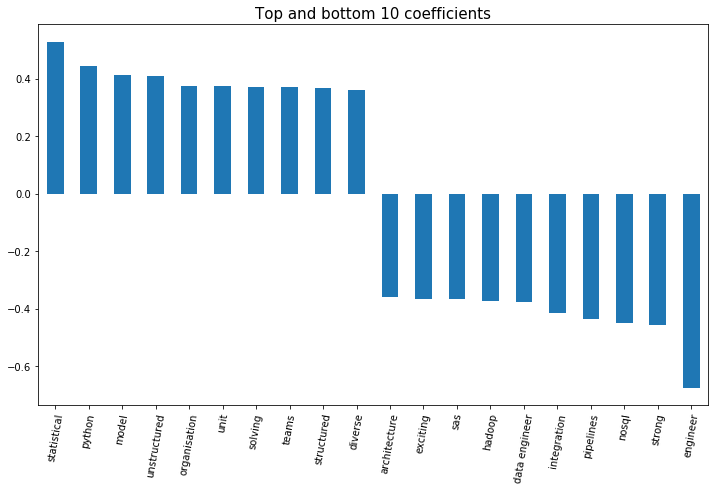

In [113]:
high = c_coefs.sort_values(by='Value',ascending=False).head(10)
low = c_coefs.sort_values(by='Value',ascending=False).tail(10)

plt.figure(figsize=(12,7))
grph = pd.concat([high,low],axis=0)['Value'].plot(kind='bar')
grph.axes.set_xticklabels(pd.concat([high,low],axis=0).index,rotation=80)
plt.title('Top and bottom 10 coefficients',fontsize=15)
plt.show()

* We've finally reached the meat of this model, the coefficient values, and they didn't disappoint!


* Coefficients that yield the highest likelihood of the job being a data scientist job are 'growth opportunities', 'machine learning' and 'business unit', an interesting mix of occurrences of words. Growth opportunities suggests that growing businesses are seeking data scientists much more than other roles, while 'business unit' highlights the importance of data scientists to businesses.


* Coefficients that yield the highest likelihood of the job being a non-data scientist role are 'opportunity join', 'minimum years', 'business intelligence'. I've chosen to ignore words that are obviously titles of non-data science jobs, but the other words are interesting. It seems that business intelligence isn't associated with data science and is probably more associated with other data roles. 

**Random Forest Classifier**

* The final model of this project will be a random forest classifier. Like with my regression model, I believe that this model will handle very large columns well and will hopefully do a better job of distinguishing data science and non- data science roles.

In [114]:
#Making the pipeline for count vectorising and the random forest classifier
rf_pipe_c = Pipeline([
    ('cvec',CountVectorizer()),
    ('rfc',RandomForestClassifier())
])

In [115]:
#Only defining countvectoriser parameters as I do not have the computation time or power to grid search random forest
#parameters, so the random forest model will only have the default values
params_allw_c = {
    'cvec__ngram_range': [(1, 1),(1, 2),(2, 2)],
    'cvec__stop_words': [custom_stop_words],
    #Grid searching for the lowest bound of occurrences of a word before it is ignored
    'cvec__min_df': list(range(1,20)),
}

In [116]:
#Defining the gridsearch object
ideal_rfc_allw = GridSearchCV(rf_pipe_c,params_allw_c,cv=5,verbose=1,n_jobs=-1)

In [117]:
#Fitting the gridsearch model
ideal_rfc_allw.fit(combined_c,y_c)

Fitting 5 folds for each of 57 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:  1.8min finished
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [118]:
#Getting the best parameters
ideal_rfc_allw.best_params_

{'cvec__min_df': 13,
 'cvec__ngram_range': (2, 2),
 'cvec__stop_words': ['everywhere',
  'what',
  'others',
  'whole',
  'could',
  'whereas',
  'sometime',
  'full',
  'only',
  'anywhere',
  'via',
  'under',
  'then',
  'give',
  'ltd',
  'amoungst',
  'first',
  'do',
  'whether',
  'am',
  'these',
  'move',
  'upon',
  're',
  'about',
  'five',
  'one',
  'anything',
  'where',
  'sixty',
  'bill',
  'must',
  'us',
  'ie',
  'formerly',
  'at',
  'my',
  'below',
  'mostly',
  'two',
  'many',
  'however',
  'never',
  'none',
  'own',
  'with',
  'should',
  'may',
  'seemed',
  'the',
  'as',
  'they',
  'when',
  'get',
  'herein',
  'is',
  'anyway',
  'twelve',
  'whenever',
  'and',
  'without',
  'elsewhere',
  'by',
  'now',
  'three',
  'thin',
  'ourselves',
  'was',
  'after',
  'such',
  'already',
  'ever',
  'name',
  'yourself',
  'had',
  'throughout',
  'another',
  'enough',
  'part',
  'namely',
  'latter',
  'therefore',
  'mill',
  'than',
  'were',
  'alm

In [119]:
#Fitting the best estimator model
rfc_allw_model = ideal_rfc_allw.best_estimator_.fit(combined_c,y_c)

In [120]:
#Getting predicted values for the model
predicted_rfc = ideal_rfc_allw.best_estimator_.predict(combined_c)

In [121]:
#Scoring based on the random forest gridsearch best estimator
scores_acc_rfc = cross_val_score(ideal_rfc_allw.best_estimator_,combined_c,y_c,cv=10,scoring='accuracy')
scores_prec_rfc = cross_val_score(ideal_rfc_allw.best_estimator_,combined_c,y_c,cv=10,scoring='precision')
scores_rec_rfc = cross_val_score(ideal_rfc_allw.best_estimator_,combined_c,y_c,cv=10,scoring='recall')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline_c)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc_rfc),'std:',np.std(scores_acc_rfc))
print('Model cv prec mean:',np.mean(scores_prec_rfc),'std:',np.std(scores_prec_rfc))
print('Model cv rec mean:',np.mean(scores_rec_rfc),'std:',np.std(scores_rec_rfc))

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/peter

Model performance:
-----------
Baseline accuracy 0.9341176470588235
-----------
Model cv acc mean: 0.9329753761969902 std: 0.0071699978930667065
Model cv prec mean: 0.18333333333333332 std: 0.32015621187164245
Model cv rec mean: 0.04 std: 0.08


* Unfortunately it seems the random forest model has underperformed the logistic regression model, and very slightly underperforms the baseline. I think this would be solved with more gridsearching for random forest hyperparameters. Unfortunately I do not have 56 hours and a supercomputer to do that, so this will have to suffice.

In [122]:
confusion_matrix(y_c,predicted_rfc)

,Predicted positive,Predicted negative
Actual Positive,53,3
Actual Negative,1,793


* The confusion matrix also confirms what I said above, it's still pretty accurate but with 5 more false negatives than the other model.

In [123]:
#Getting the feature importances
rfc_feats = ideal_rfc_allw.best_estimator_.named_steps['rfc'].feature_importances_

In [124]:
#Putting the names of the vectorised columns into a data frame
names_rfc = pd.DataFrame(ideal_rfc_allw.best_estimator_.named_steps['cvec'].transform(combined_c).todense(),
                       columns=ideal_rfc_allw.best_estimator_.named_steps['cvec'].fit(combined_c).get_feature_names())

In [125]:
#Zipping the feature names and feature importance values into a dataframe for analysis
rfc_feat_df = pd.DataFrame(dict(zip(names_rfc.columns,rfc_feats)),index=['Value']).T
rfc_feat_df.sort_values(by='Value',ascending=False)

,Value
machine learning,0.031697
python sql,0.023989
data join,0.023711
data projects,0.013710
data mining,0.013102
data analytics,0.012621
language processing,0.009406
end end,0.009231
gov au,0.008954
structured unstructured,0.008629


<Figure size 864x504 with 0 Axes>

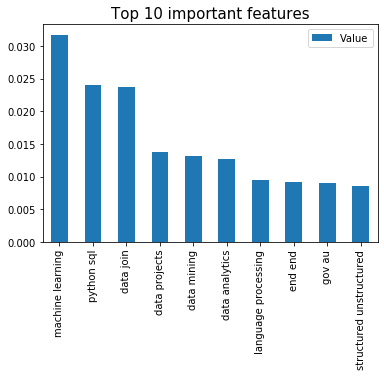

In [126]:
plt.figure(figsize=(12,7))
rfc_feat_df.sort_values(by='Value',ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 important features',fontsize=15)
plt.show()

* What this model lacks in predictive power in comparison to the logistic regression model, it makes up for in the insights one can gain from its feature importance rankings. I think this list of top 10 important features that distinguish data science and non data science roles is superior to the coefficients from the logistic regression model.


* Key words like 'models', 'machine', 'learning', and  'algorithms' make perfect sense as to being distinguishing features that separate data science and non data science roles from one another. This suggests the importance of machine learning skills when applying for a data science role.